# Setup ENV

In [1]:
# %pip install statsmodels

# Imports

In [2]:
import glob
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

## Data preparing

### Load all data as one
create all data with day-of-week aggregation

In [3]:
## list all data files
data_files = glob.glob("data/*.ods")
dayofweek_summary_data_ = pd.DataFrame()

for file in data_files:
    data_ = pd.read_excel(file, engine="odf", index_col=None)
    data_.rename(columns={"            StationDate": "StationDate"}, inplace=True)
    data_["day_of_week"] = data_['StationDate'].dt.day_name()

    dayofweek_data_ = data_.drop(columns="StationDate").groupby("day_of_week").agg("mean")
    dayofweek_data_ = dayofweek_data_.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]).transpose()
    dayofweek_data_["year_month"] = file.split(".")[0].split("_")[0].split("/")[1]

    dayofweek_data_.reset_index(inplace=True)

    dayofweek_summary_data_ = pd.concat([dayofweek_summary_data_, dayofweek_data_], axis=0)

print(dayofweek_summary_data_.shape)

dayofweek_summary_data_.rename(columns={"index": "StationName"}, inplace=True)



(4165, 9)


In [4]:
## melt data form
long_dayofweek_summary_data = pd.melt(dayofweek_summary_data_, id_vars=["StationName", "year_month"], 
                                      value_vars=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
long_dayofweek_summary_data = long_dayofweek_summary_data.sort_values(["StationName", "year_month"]).reset_index(drop=True)
print(long_dayofweek_summary_data.shape)

(29155, 4)


In [5]:
## aggregate by month
long_month_summary_data = long_dayofweek_summary_data.groupby(["StationName", "year_month"], as_index=False).agg("mean", numeric_only=True)

### Add label information

In [6]:
group0_Stations = pd.read_csv("results/group0_StationName.csv", index_col=0)
group1_Stations = pd.read_csv("results/group1_StationName.csv", index_col=0)
group2_Stations = pd.read_csv("results/group2_StationName.csv", index_col=0)
group3_Stations = pd.read_csv("results/group3_StationName.csv", index_col=0)

def group_index(row):
    if row["StationName"] in group0_Stations["StationName"].tolist():
        return "group0"
    elif row["StationName"] in group1_Stations["StationName"].tolist():
        return "group1"
    elif row["StationName"] in group2_Stations["StationName"].tolist():
        return "group2"
    elif row["StationName"] in group3_Stations["StationName"].tolist():
        return "group3"
    else:
        return "None_group"

long_month_summary_data["cluster"] = long_month_summary_data.apply(lambda row: group_index(row), axis=1)
long_month_summary_data = long_month_summary_data[long_month_summary_data["cluster"] != "None_group"]

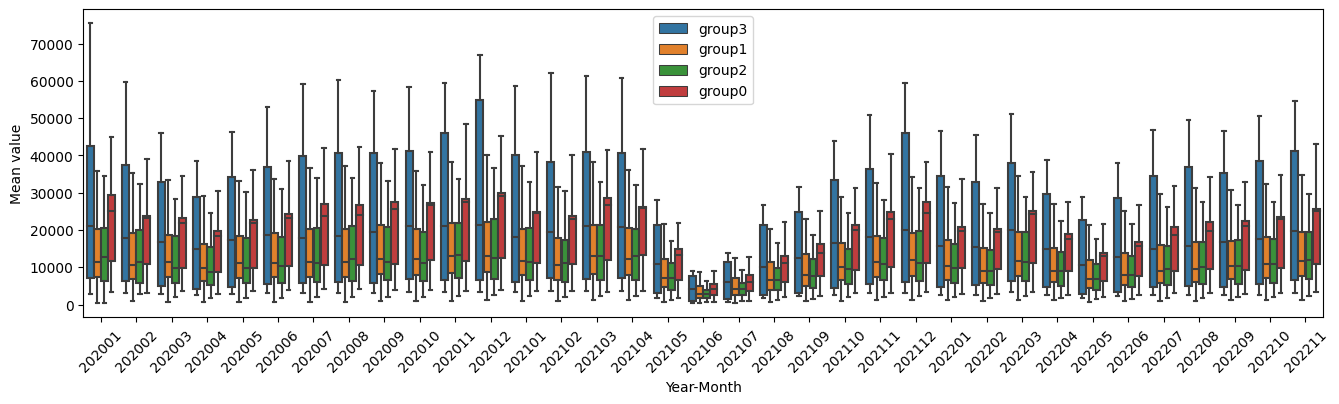

In [7]:
plt.figure(figsize=(16, 4))
sns.boxplot(
    data=long_month_summary_data,
    x="year_month", y="value", hue="cluster",
    showfliers = False
)
plt.xlabel("Year-Month")
plt.ylabel("Mean value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [8]:
group0_data = long_month_summary_data[long_month_summary_data["cluster"] == "group0"]
group1_data = long_month_summary_data[long_month_summary_data["cluster"] == "group1"]
group2_data = long_month_summary_data[long_month_summary_data["cluster"] == "group2"]
group3_data = long_month_summary_data[long_month_summary_data["cluster"] == "group3"]

### Median test (K-W test)
significantly different

In [9]:
before_outbreak = long_month_summary_data[long_month_summary_data["year_month"] < "202106"]
after_outbreak = long_month_summary_data[long_month_summary_data["year_month"] > "202106"]
stats.kruskal(before_outbreak["value"], after_outbreak["value"])

KruskalResult(statistic=70.90914010748526, pvalue=3.740609850014626e-17)

In [10]:
stats.kruskal(group0_data["value"], group1_data["value"], group2_data["value"], group3_data["value"])

KruskalResult(statistic=185.09029348667013, pvalue=7.016378235021197e-40)

### Heatmaps to show trend

In [11]:
heatmap_group0_data = group0_data.pivot_table(index=["StationName"], columns="year_month", values="value")
heatmap_group1_data = group1_data.pivot_table(index=["StationName"], columns="year_month", values="value")
heatmap_group2_data = group1_data.pivot_table(index=["StationName"], columns="year_month", values="value")
heatmap_group3_data = group3_data.pivot_table(index=["StationName"], columns="year_month", values="value")

In [12]:
scaler = MinMaxScaler()
scaled_heatmap_group0_data = pd.DataFrame(scaler.fit_transform(heatmap_group0_data.transpose()), index=heatmap_group0_data.columns, columns=heatmap_group0_data.index).transpose()
scaled_heatmap_group1_data = pd.DataFrame(scaler.fit_transform(heatmap_group1_data.transpose()), index=heatmap_group1_data.columns, columns=heatmap_group1_data.index).transpose()
scaled_heatmap_group2_data = pd.DataFrame(scaler.fit_transform(heatmap_group2_data.transpose()), index=heatmap_group2_data.columns, columns=heatmap_group2_data.index).transpose()
scaled_heatmap_group3_data = pd.DataFrame(scaler.fit_transform(heatmap_group3_data.transpose()), index=heatmap_group3_data.columns, columns=heatmap_group3_data.index).transpose()

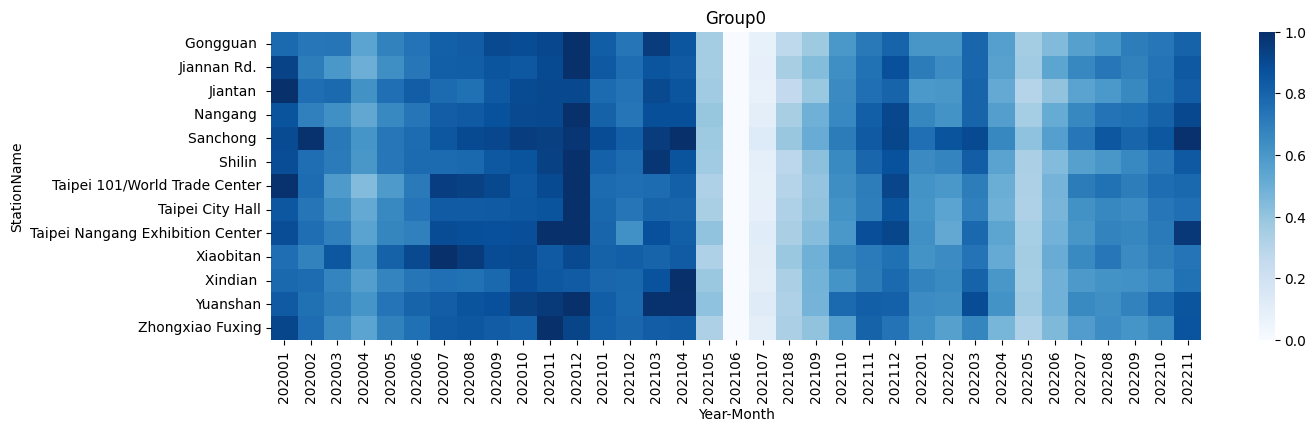

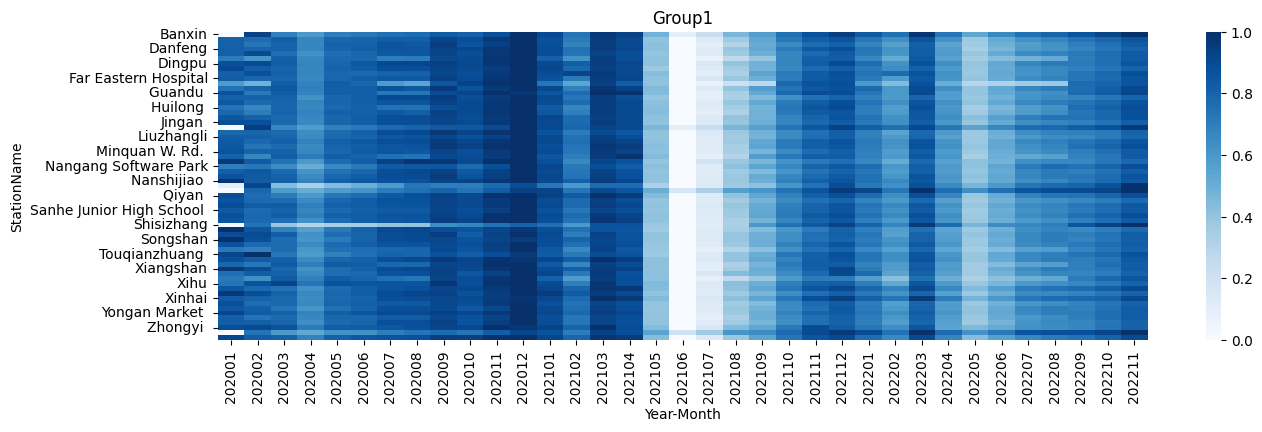

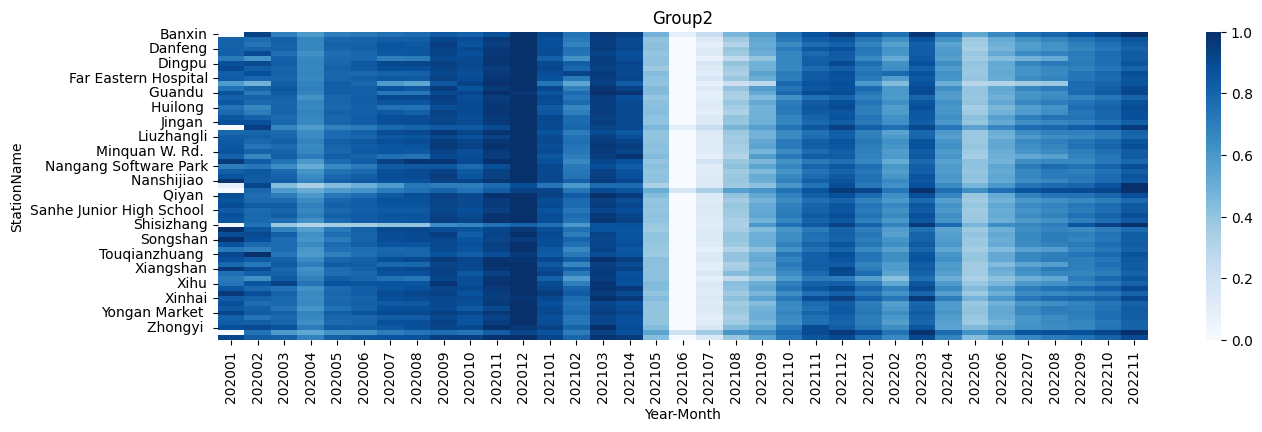

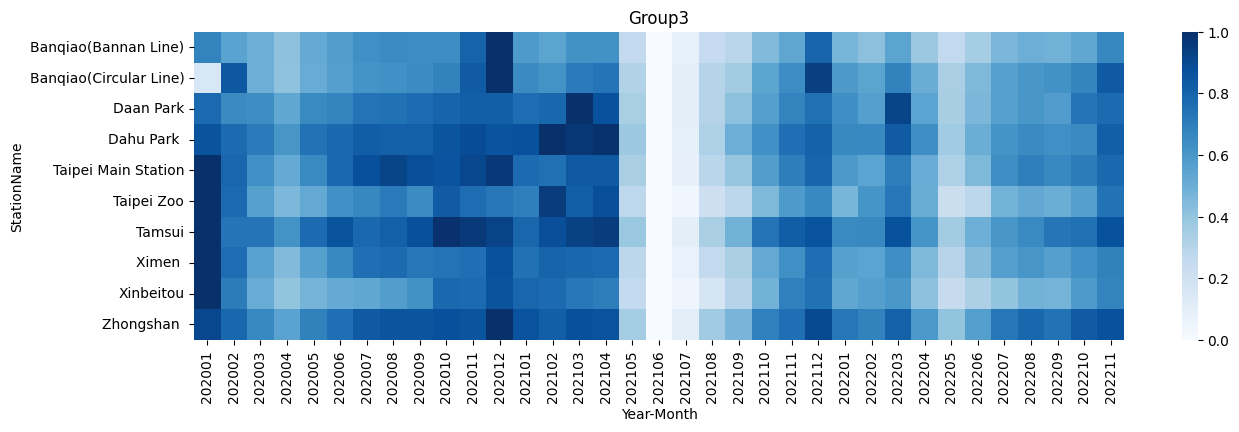

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(scaled_heatmap_group0_data, cmap="Blues")
ax.set_title("Group0")
ax.set_xlabel("Year-Month")
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(scaled_heatmap_group1_data, cmap="Blues")
ax.set_title("Group1")
ax.set_xlabel("Year-Month")
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(scaled_heatmap_group2_data, cmap="Blues")
ax.set_title("Group2")
ax.set_xlabel("Year-Month")
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(scaled_heatmap_group3_data, cmap="Blues")
ax.set_title("Group3")
ax.set_xlabel("Year-Month")
plt.show()

In [14]:
## checking colorbar limits
print(long_month_summary_data["value"].min(), long_month_summary_data["value"].max())

293.0857142857143 148818.97857142857


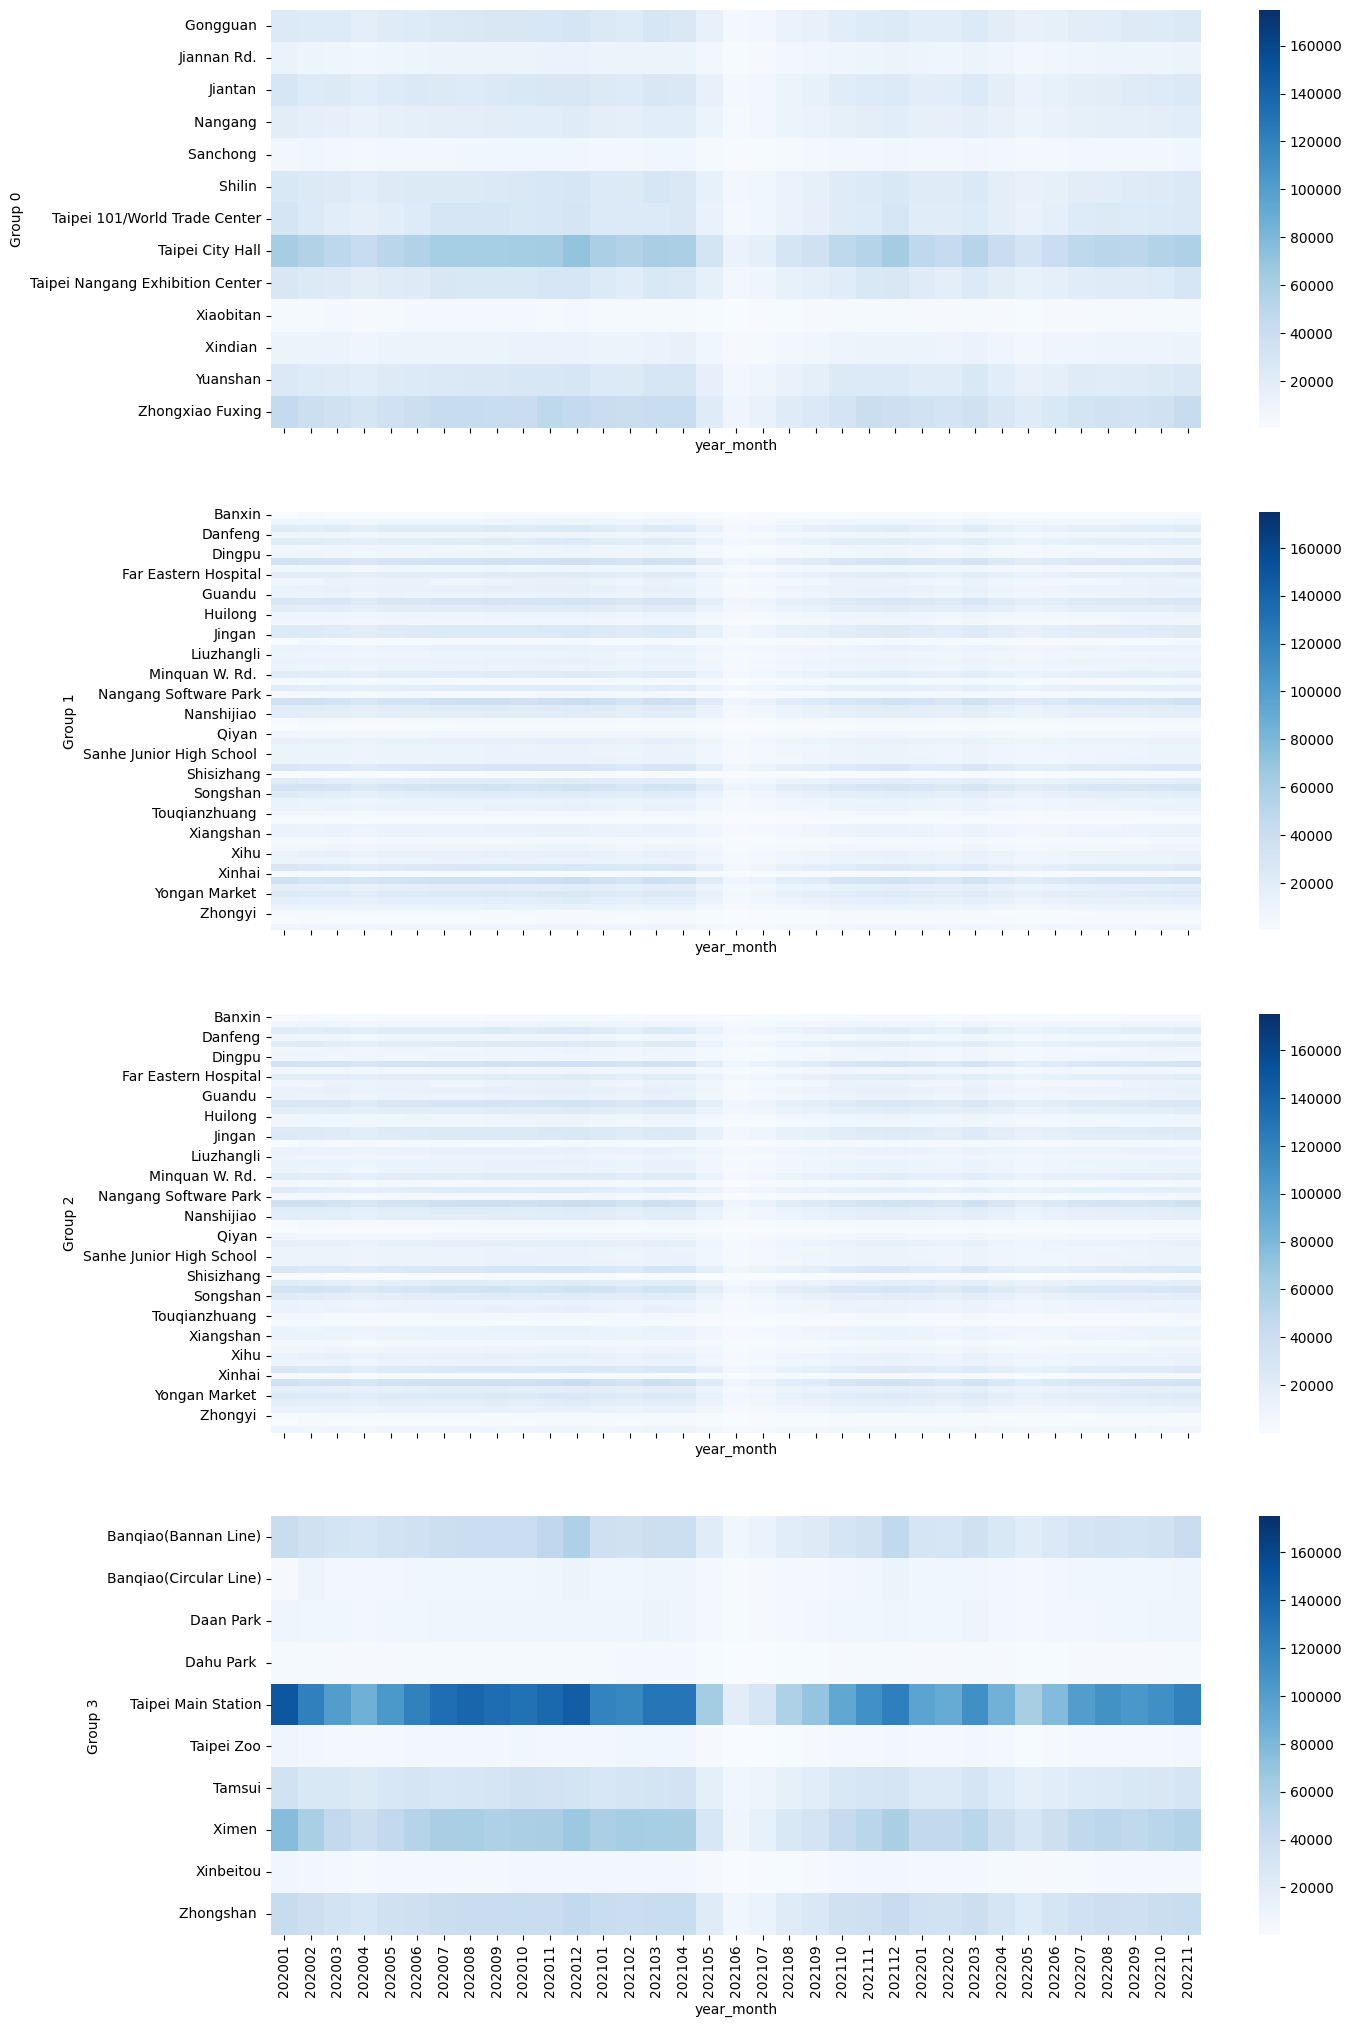

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 25), sharex=True)
sns.heatmap(heatmap_group0_data, ax=ax1, cmap="Blues", vmin=250, vmax=175000)
sns.heatmap(heatmap_group1_data, ax=ax2, cmap="Blues", vmin=250, vmax=175000)
sns.heatmap(heatmap_group2_data, ax=ax3, cmap="Blues", vmin=250, vmax=175000)
sns.heatmap(heatmap_group3_data, ax=ax4, cmap="Blues", vmin=250, vmax=175000)

ax1.set_ylabel("Group 0")
ax2.set_ylabel("Group 1")
ax3.set_ylabel("Group 2")
ax4.set_ylabel("Group 3")

plt.show()

# plt.savefig(f"img/{target_name}-{baseline_name}_heatmap_weekday_compare.png", bbox_inches="tight", pad_inches=0.1)
# plt.close()

# Some timeseries trying

In [16]:

def get_day_data_of_group(group_name_df):
    day_summary_data_group_ = pd.DataFrame()

    for file in data_files:
        data_ = pd.read_excel(file, engine="odf", index_col=None)
        data_.rename(columns={"            StationDate": "StationDate"}, inplace=True)
        group_data_ = data_[list(set(data_.columns).intersection(group_name_df["StationName"]))]
        group_data_ = group_data_.join(data_["StationDate"])
        group_day_ = pd.DataFrame(group_data_.mean(axis=1, numeric_only=True))
        group_day_ = group_day_.join(data_["StationDate"])

        day_summary_data_group_ = pd.concat([day_summary_data_group_, group_day_], axis=0)

    day_summary_data_group_.columns = ["value", "StationDate"]
    day_summary_data_group_.set_index("StationDate", inplace=True)
    return day_summary_data_group_

day_summary_data_group0 = get_day_data_of_group(group0_Stations)
day_summary_data_group1 = get_day_data_of_group(group1_Stations)
day_summary_data_group2 = get_day_data_of_group(group2_Stations)
day_summary_data_group3 = get_day_data_of_group(group3_Stations)

In [17]:
import numpy as np

import statsmodels.tsa.api as smt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


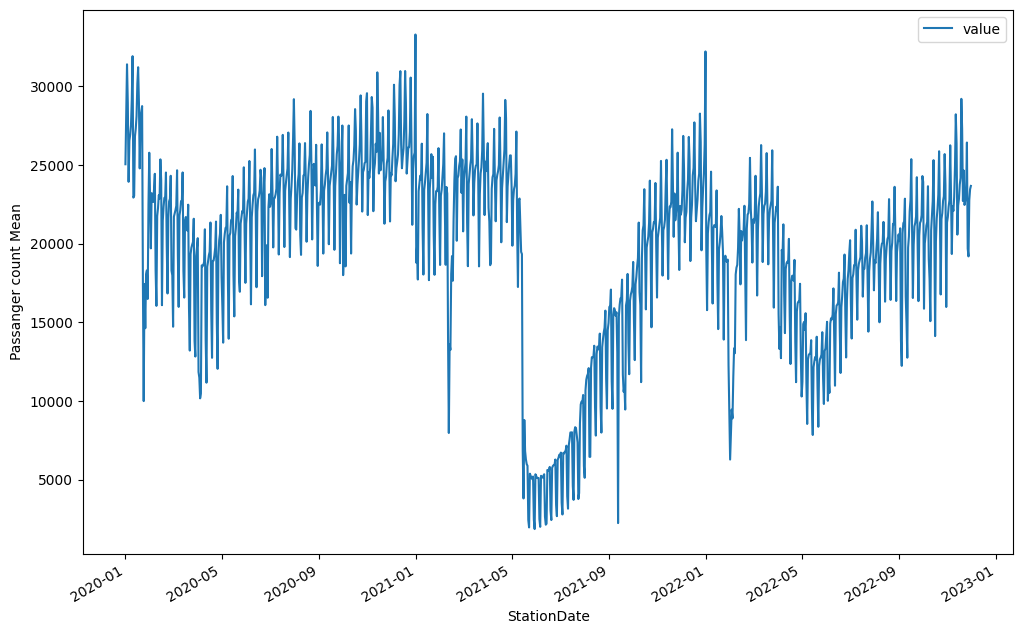

In [20]:
timeseries_data = day_summary_data_group0[["value"]]
timeseries_data.plot(figsize=(12, 8), label="Group 0")
plt.ylabel("Passanger count Mean")
plt.legend()
plt.show()

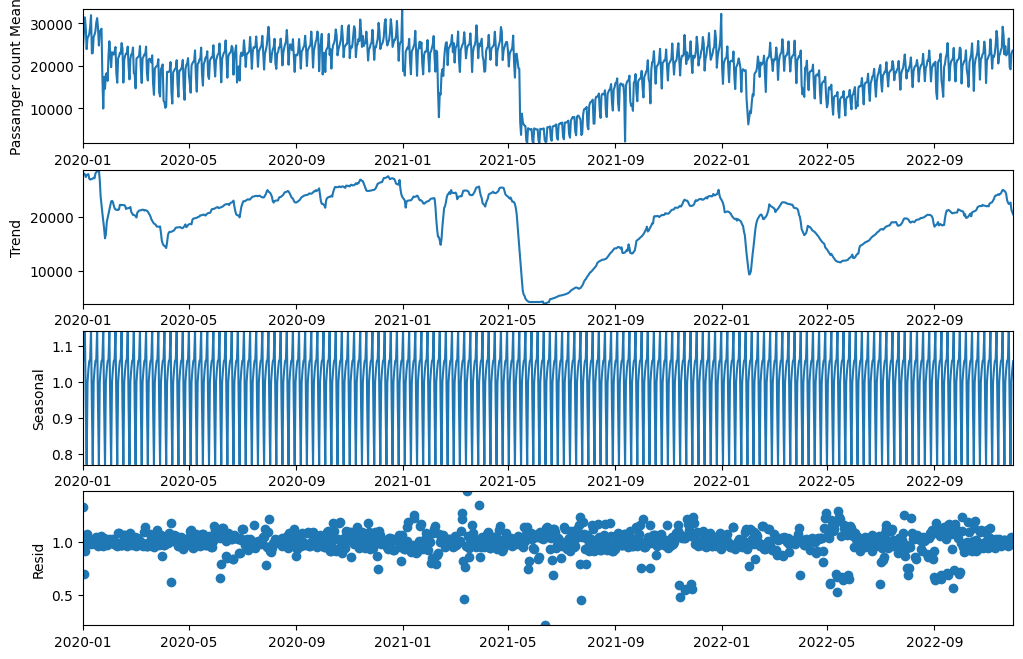

In [21]:
timeseries_data.sort_index(inplace=True)
result = seasonal_decompose(timeseries_data, model="multiplicative", extrapolate_trend=7)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label="Group 0")
plt.ylabel("Passanger count Mean")
# plt.xticks(day_summary_data_group0.index[::30], rotation=45) 
plt.margins(0)
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.ylabel("Trend")
# plt.xticks(day_summary_data_group0.index[::30], rotation=45)
plt.margins(0)
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
# plt.xticks(day_summary_data_group0.index[::30], rotation=45)
plt.margins(0)
plt.subplot(4, 1, 4)
plt.scatter(day_summary_data_group0.index, result.resid)
plt.ylabel("Resid")
# plt.xticks(day_summary_data_group0.index[::30], rotation=45)
plt.margins(0)

In [22]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")

adf_test(timeseries_data)

Results of Dickey-Fuller Test
Test Statistic                   -2.939465
p-value                           0.040947
#Lags Used                       21.000000
Number of Observations Used    1043.000000
Criterical Value (1%)            -3.436635
Criterical Value (5%)            -2.864315
Criterical Value (10%)           -2.568248
dtype: float64
The data is stationary. (Criterical Value 5%)


Results of Dickey-Fuller Test
Test Statistic                -6.168876e+00
p-value                        6.882537e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.035000e+03
Criterical Value (1%)         -3.436684e+00
Criterical Value (5%)         -2.864337e+00
Criterical Value (10%)        -2.568259e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


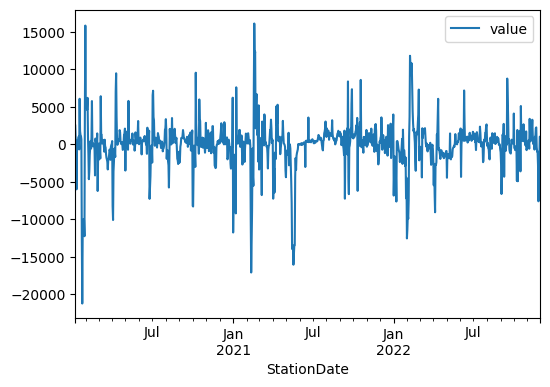

In [23]:
diff_7 = timeseries_data - timeseries_data.shift(7) 
diff_7 = diff_7.dropna()
diff_7.head()
diff_7.plot(figsize=(6,4), label="diff_7")
plt.legend()

adf_test(diff_7)

Results of Dickey-Fuller Test
Test Statistic                -1.160366e+01
p-value                        2.612166e-21
#Lags Used                     2.100000e+01
Number of Observations Used    1.028000e+03
Criterical Value (1%)         -3.436727e+00
Criterical Value (5%)         -2.864356e+00
Criterical Value (10%)        -2.568269e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


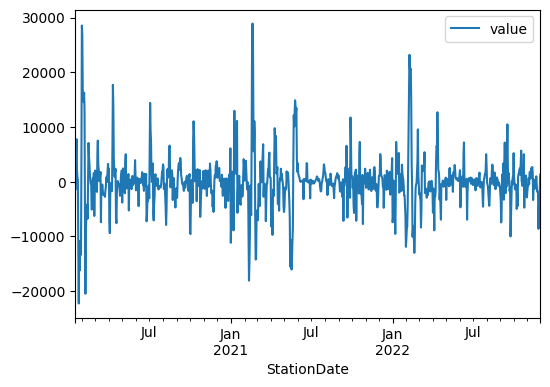

In [24]:
diff_7_8 = diff_7 - diff_7.shift(8) 
diff_7_8 = diff_7_8.dropna()
diff_7_8.head()
diff_7_8.plot(figsize=(6, 4), label="diff_7_8")
plt.legend()

adf_test(diff_7_8)

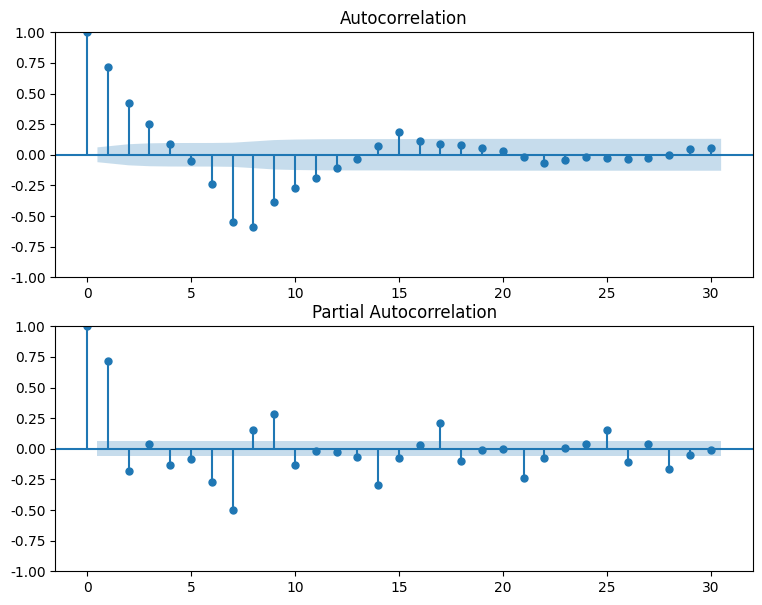

In [25]:
#correlogram
f = plt.figure(facecolor="white", figsize=(9, 7))
ax1 = f.add_subplot(211)
plot_acf(diff_7_8, lags=30, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(diff_7_8, lags=30, ax=ax2,  method="ywm")
plt.rcParams["axes.unicode_minus"] = False 
plt.show()

/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates

ARIMA(0,1,0):AIC=20143.50437899647
ARIMA(0,1,1):AIC=20145.180240657326
ARIMA(0,1,2):AIC=20100.427917106652
ARIMA(1,1,0):AIC=20145.310378067596
ARIMA(1,1,1):AIC=20136.05923727899


/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1,1,2):AIC=19954.830263047053
ARIMA(2,1,0):AIC=20102.88287009389
ARIMA(2,1,1):AIC=20103.86535858567


/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates

ARIMA(2,1,2):AIC=19954.398228399165
ARIMA(3,1,0):AIC=20104.39535388448


/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates

ARIMA(3,1,1):AIC=19959.92939161549
ARIMA(3,1,2):AIC=19934.6587340829
This best model is ARIMA(3,1,2) based on argmin AIC.


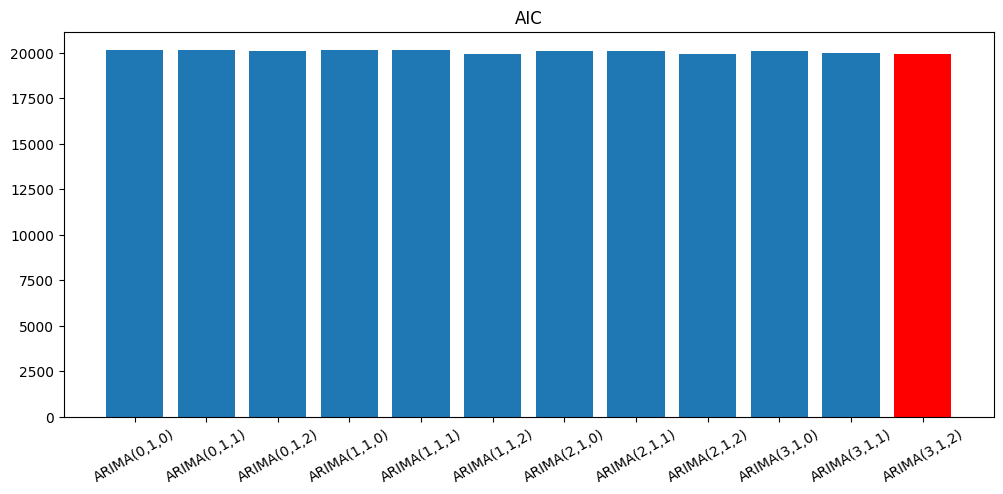

In [26]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq", 30000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1, d):
            for k in range(q):            
                model = ARIMA(data, order=(i, j, k))
                fitted = model.fit()
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k}):AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.savefig("Arima AIC")
    plt.show()
arima_AIC(diff_7_8, 4,2,3)

In [27]:
model = ARIMA(timeseries_data, order=(3, 1, 2))
fitted = model.fit()

fitted.summary()

/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ccchen-jerry/Documents/production_Pyhon/mrt/assignment/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  war

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 1065
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -9937.367
Date:                Wed, 21 Dec 2022   AIC                          19886.735
Time:                        22:30:15   BIC                          19916.553
Sample:                    01-01-2020   HQIC                         19898.034
                         - 11-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3600      0.104     -3.454      0.001      -0.564      -0.156
ar.L2          0.1189      0.053      2.239      0.025       0.015       0.223
ar.L3         -0.1551      0.051     -3.012      0.003      -0.256      -0.054
ma.L1          0.0506      0.102      0.496      0.620      -0.149       0.250
ma.L2         -0.6656      0.070     -9.561      0.000      -0.802      -0.529
sigma2      6.652e+06   1.95e+05     34.096      0.000    6.27e+06    7.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               212.22
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.74
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

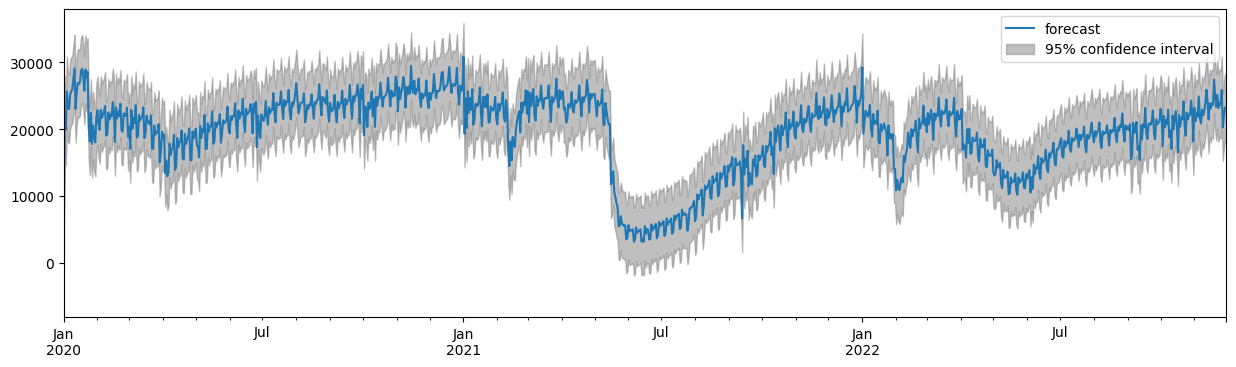

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_predict(fitted, ax=ax)
plt.show()